In [1]:
import pandas as pd
%matplotlib inline
import pylab as plt
import numpy as np
import scipy as sc
import scipy.stats

## Load up data
The data has already been pre-processed. Also, drop the silly region column that is now obsolete

In [2]:
data = pd.read_csv('data/processed.csv')
data = data.drop(columns=['region'])
data

,campus,year,school,school_num,city,county,state,country,ethnicity,app_num,adm_num,enr_num,app_gpa,adm_gpa,enr_gpa
0,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,51520,Los Angeles,Los Angeles,California,USA,All,14.0,NaN,NaN,3.620000,NaN,NaN
1,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,51520,Los Angeles,Los Angeles,California,USA,Asian,8.0,NaN,NaN,3.620000,NaN,NaN
2,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,51520,Los Angeles,Los Angeles,California,USA,Hispanic/ Latino,5.0,NaN,NaN,3.620000,NaN,NaN
3,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,52910,San Francisco,San Francisco,California,USA,All,58.0,8.0,7.0,3.682931,4.121250,4.088571
4,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,52910,San Francisco,San Francisco,California,USA,Asian,50.0,8.0,7.0,3.682931,4.121250,4.088571
5,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,53075,San Jose,Santa Clara,California,USA,All,14.0,NaN,NaN,3.640714,NaN,NaN
6,Berkeley,1994,ABRAHAM LINCOLN HIGH SCHOOL,53075,San Jose,Santa Clara,California,USA,Hispanic/ Latino,6.0,NaN,NaN,3.640714,NaN,NaN
7,Berkeley,1994,ACADEMY OUR LADY OF PEACE,52820,San Diego,San Diego,California,USA,All,5.0,NaN,NaN,3.786000,NaN,NaN
8,Berkeley,1994,ACALANES HIGH SCHOOL,51315,Lafayette,Contra Costa,California,USA,All,61.0,30.0,13.0,3.557869,3.828333,3.563846
9,Berkeley,1994,ACALANES HIGH SCHOOL,51315,Lafayette,Contra Costa,California,USA,Asian,16.0,4.0,NaN,3.557869,3.828333,NaN


## Check out NaNs
How many of our measurements are NaN? Look at percentage of all GPA columns that are valid:

In [3]:
### check the number of NaN's in applied, admitted and enrolled students' GPA
nrows = len(data)
nan_app_gpa = data['app_gpa'].count() / nrows
nan_adm_gpa = data['adm_gpa'].count() / nrows
nan_enr_gpa = data['enr_gpa'].count() / nrows

print('NaN app = %0.2f\nNaN adm = %0.2f\nNaN enr = %0.2f' %(nan_app_gpa, nan_adm_gpa, nan_enr_gpa))

NaN app = 1.00
NaN adm = 0.70
NaN enr = 0.26


## Preliminary Yield Correlation
We want to predict yield, so let's look at what features correlate with yield. First let's try the admitted gpa. The higher the admitted GPA, the more prestigious the school so maybe the higher yield rate?

In [4]:
def plot_corr(data, x_col, y_col):
    valid_data = data.dropna(subset=[x_col, y_col], how='any')
    x, y = valid_data[x_col], valid_data[y_col]
    heatmap, xedges, yedges =  np.histogram2d(x, y, bins=(15,15))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    plt.imshow(heatmap, extent=extent)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title('Heat Diagram')
    plt.show()

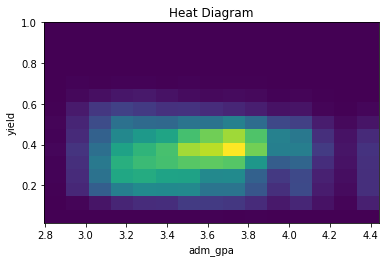

In [5]:
data['yield'] = data['enr_num'] / data['adm_num']
plot_corr(data, 'adm_gpa' ,'yield')

In [6]:
data['adm_gpa'].corr(data['yield'])

0.006968176907384733

There does not seem to be any correlation. Maybe if we create our own features. Perhaps the yield rate isn't about actual difficulty of getting in (adm_gpa) but the **relative** difficulty of getting in from the students' perspective. Therefore we can estimate the relative difficulty by looking at the difference between the applied and accepted GPA. The larger the difference, the more those students are "reaching" for that school.

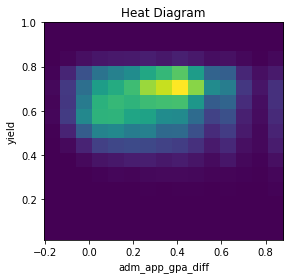

In [7]:
data['adm_app_gpa_diff'] = data['adm_gpa'] - data['app_gpa']
plot_corr(data, 'adm_app_gpa_diff', 'yield')

In [8]:
data['adm_app_gpa_diff'].corr(data['yield'])

-0.04265997152316723

So, there seems to be a bit more correlation here, but still it isn't enough to pursue any more. Maybe we measure desirability some other way. How about admission rates?

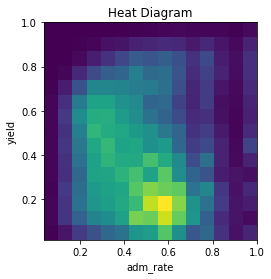

In [9]:
data['adm_rate'] = data['adm_num'] / data['app_num']
plot_corr(data, 'adm_rate', 'yield')

In [10]:
data['adm_rate'].corr(data['yield'])

0.03483706641838552

Well that also looks bad, with the correlation coefficient, as well as the plot. It seems like in the lower left corner that a lower admission rate sort of implies higher yield (which makes sense), but this is thrown off by the middle top.

### Yield Rate vs Year

Unfortunately, by doing correlation analysis between various GPA related variables and yield rate, we were unable to find significant correlation between GPA variables and yield rate, which we previously assumed to have great influence on our prediction. Next, we want to check if there would be any correlation between the yield rate and year. Specifically, we are interested to see how the yield rate changes with respect to different years. In this plot, we took all nine of the UC campuses into account and calculate the average yield rate for each year. The plot shows us some sorts of trend of the yield rate. Before 2010, it had been gradually decreasing, but after 2010, the tendency began to rise up and finally fell after a short period of time. After examining this plot, we would like to look closely into the cause factors of the change in yield rate. 

(0, 1)

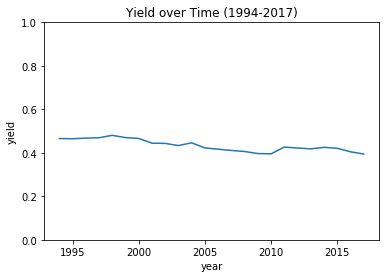

In [11]:
def find_yield(data, yr):
    right_year = data[data['year'] == yr]
    valid = right_year.dropna(subset=['enr_num', 'adm_num'], how='any')
    return valid['enr_num'].sum() / valid['adm_num'].sum()

yield_yr = []
yr = np.arange(1994, 2018)

for y in yr:
    yield_yr.append(find_yield(data, y))
    
plt.plot(yr, yield_yr)
plt.xlabel('year')
plt.ylabel('yield')
plt.title('Yield over Time (1994-2017)')
plt.ylim(0, 1)

## Yield vs Race
Perhaps if we perform the same analysis, but keeing race and UC campus as different categories then trends will be more clear...

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


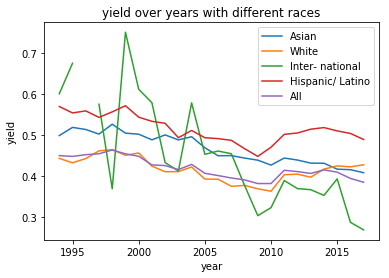

In [12]:
def find_yield_race(data, race, yr):
    right_data = data[(data['ethnicity'] == race) & (data['year'] == yr)]
    valid = right_data.dropna(subset=['enr_num', 'adm_num'], how='any')
    return valid['enr_num'].sum() / valid['adm_num'].sum()

race = ['Asian', 'White', 'Inter- national', 'Hispanic/ Latino', 'All']
yield_race_yr = [[], [], [], [], []]

for i in range(0, len(race)):
    for y in yr:
        yield_race_yr[i].append(find_yield_race(data, race[i], y))

for i in range(0, len(race)):
    plt.plot(yr, yield_race_yr[i], label=race[i])

plt.xlabel('year')
plt.ylabel('yield')
plt.title('yield over years with different races')
plt.legend(bbox_to_anchor=(1., 1.0))

It doesn't look like there are that interesting of trends here. We could probably get away with throwing out the race information completely. The international data looks all wonky at the beginning, let's check that to see if that is maybe getting caused by a small number of entries:

In [13]:
data.loc[data['ethnicity']=='Inter- national'].dropna(subset=['enr_num', 'adm_num'], how='any').groupby('year').count()

,campus,school,school_num,city,county,state,country,ethnicity,app_num,adm_num,enr_num,app_gpa,adm_gpa,enr_gpa,yield,adm_app_gpa_diff,adm_rate
year,,,,,,,,,,,,,,,,,
1994,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1
1995,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
1997,7,7,7,6,6,6,7,7,7,7,7,7,7,7,7,7,7
1998,2,2,2,0,0,0,2,2,2,2,2,2,2,2,2,2,2
1999,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2000,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2001,10,10,10,9,9,9,10,10,10,10,10,10,10,10,10,10,10
2002,5,5,5,0,0,0,0,5,5,5,5,5,5,5,5,5,5
2003,5,5,5,2,2,2,2,5,5,5,5,5,5,5,5,5,5


Yep, looks like there are only a few rows for the early years.
## Yield vs Campus

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


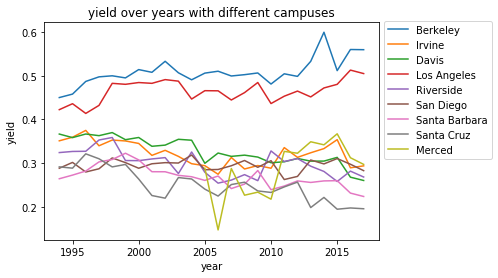

In [14]:
def find_yield_campus(data, camp, yr):
    right_data = data[(data['campus'] == camp) & (data['year'] == yr)]
    valid = right_data.dropna(subset=['enr_num', 'adm_num'], how='any')
    return valid['enr_num'].sum() / valid['adm_num'].sum()

campus = ['Berkeley', 'Irvine', 'Davis', 'Los Angeles', 'Riverside', 'San Diego',
               'Santa Barbara', 'Santa Cruz', 'Merced']

yield_camp_yr = [[], [], [], [], [], [], [], [], []]

yr_reduced = np.arange(1994, 2018)

for i in range(0, len(campus)):
    for y in yr_reduced:
        yield_camp_yr[i].append(find_yield_campus(data, campus[i], y))

for i in range(0, len(campus)):
    plt.plot(yr_reduced, yield_camp_yr[i], label=campus[i])

plt.xlabel('year')
plt.ylabel('yield')
plt.title('yield over years with different campuses')
plt.legend(bbox_to_anchor=(1.0, 1.03))

It looks like the yield rate of Berkely and Los Angeles is much higher than the others over time, which agrees with our intuition that they are more prestigious schools. This could be important if we want to predict different yield rates for different campuses. It also could be important for if we want to combine other features for our final prediction. For instance, because the actual campus seems to make so much of a difference, then we had better pay attention to location more. We could try to look at the relative locations of campuses to high schools, since students may be more likely to attend campuses that are closer to home.
## Yield Rate Distributions for different campuses 
This previous plot makes it appear that different campuses have different yield rates. Let's actually test this hypothesis.

In [15]:
def plot_probs(camp1_values, camp2_values, camp1, camp2, bins=20):
    fig = plt.figure()
    # add the first subplot
    ax = fig.add_subplot(111)
    # extract the data from the dataframe
    # return the same shape of the data and but all the elements in 
    # the array are 1
    weights = np.ones_like(camp1_values)/len(camp1_values)
    # this is the histogram
    _ = ax.hist(camp1_values, bins=bins, alpha=0.3, label=[camp1], weights=weights)
    weights = np.ones_like(camp2_values)/len(camp2_values)
    _ = ax.hist(camp2_values, bins=bins, color='red', alpha=.3, label=camp2, weights=weights)
    ax.set_xlabel('yield rate', fontsize=14)
    ax.set_ylabel('Probability', fontsize=14)
    ax.vlines(np.mean(camp1_values), 0.0, ax.get_ylim()[1], colors='b', linestyle='--', linewidth=4)
    ax.vlines(np.mean(camp2_values), 0.0, ax.get_ylim()[1], colors='r', linestyle='--', linewidth=4)
    ax.legend()
    
camp_yield = {}

for c in campus:
    camp_values = data[data['campus']==c]['yield'].values
    camp_values = camp_values[~np.isnan(camp_values)]
    camp_yield[c] = camp_values

Let's look at the distribution of yield rates for the Berkeley and LA campuses. On the plot above they seemed to have a similar rate. Let's see if the distributions are normal, and then do a T-test to see if they are the same distribution...

NormaltestResult(statistic=203.65430081922023, pvalue=5.984535798133254e-45)
NormaltestResult(statistic=282.51165822006334, pvalue=4.501661971532998e-62)
Ttest_indResult(statistic=6.741198966745834, pvalue=1.6350679066159484e-11)


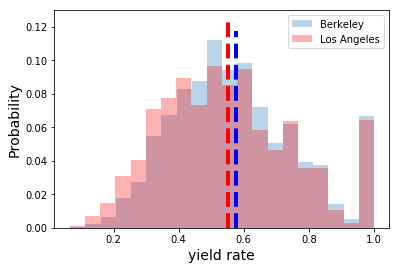

In [16]:
from scipy.stats import ttest_ind as ttest
from scipy.stats import normaltest

print(normaltest(camp_yield['Berkeley']))
print(normaltest(camp_yield['Los Angeles']))
print(ttest(camp_yield['Berkeley'], camp_yield['Los Angeles']))
plot_probs(camp_yield['Berkeley'], camp_yield['Los Angeles'], 'Berkeley', 'Los Angeles')

NormaltestResult(statistic=203.65430081922023, pvalue=5.984535798133254e-45)
NormaltestResult(statistic=1124.8115567326427, pvalue=5.62696048041664e-245)
Ttest_indResult(statistic=74.20007080252822, pvalue=0.0)


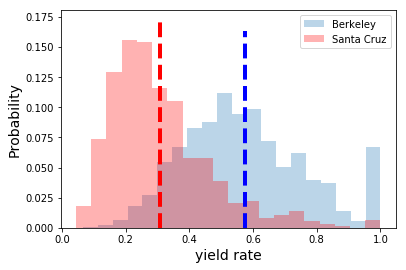

In [17]:
print(normaltest(camp_yield['Berkeley']))
print(normaltest(camp_yield['Santa Cruz']))
print(ttest(camp_yield['Berkeley'], camp_yield['Santa Cruz']))
plot_probs(camp_yield['Berkeley'], camp_yield['Santa Cruz'], 'Berkeley', 'Santa Cruz')

None of these ditributions appear to be normal according to the T-test, which doesn't make total sense to us, since some of them certainly look approximately normal. Perhaps the large densities at the tails are throwing things off. Maybe it is a sampling issue too. Let's look at the histogram, but with more buckets:

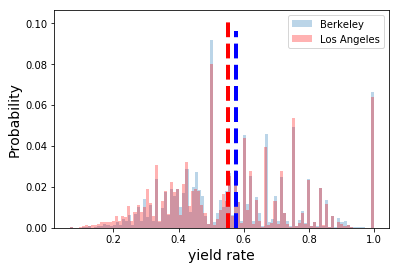

In [18]:
plot_probs(camp_yield['Berkeley'], camp_yield['Los Angeles'], 'Berkeley', 'Los Angeles', bins=100)

Ah ha! So these yield rates definitely aren't normal, since they follow such a comb-like pattern. This is probably just a sampling problem: notice how the density of .5 yield is so high: there are probably lots of instances where the enrolled number is perfectly half of the admitted number. The weird ratios such as just above or below .5 aren't hit because we are dealing with such small numbers.

Since the normal test is failing so badly, it's not surprising that the T-test is failing as well. Of course the computer thinks the two yield rates don't come from the distribution, since they don't seem to come from distributions at all! But to us it **does** look like Berkeley and UCLA come from the same distribution, so probably these builtin tests are not what we want. Ideally we could use some other test to check if they come from the same distribution.

## Yield rate by high school
We have tried to determine yield's correlation with race and campus and time. Finally let's see if we can find patterns as related to high school. Let's make a plot for each high school showing the yield rate as it varies over time.

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


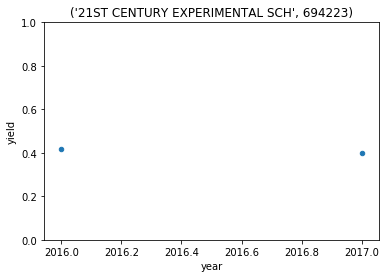

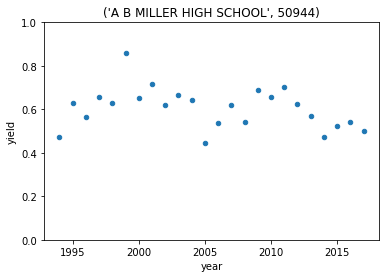

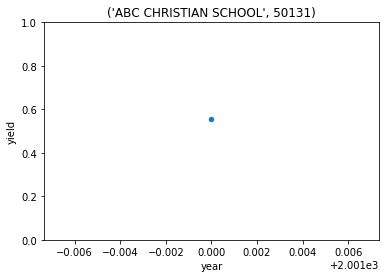

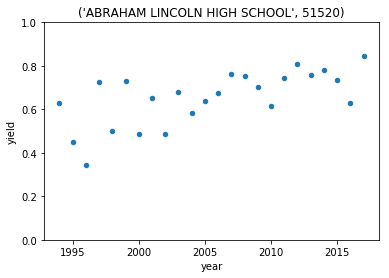

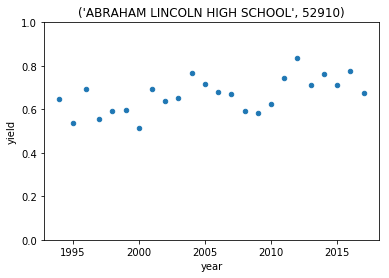

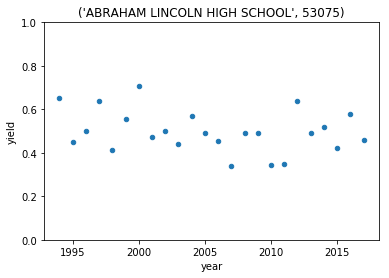

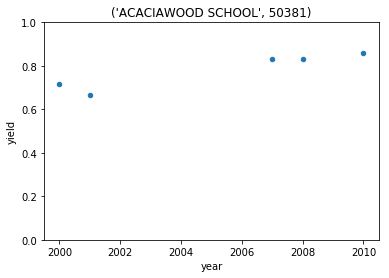

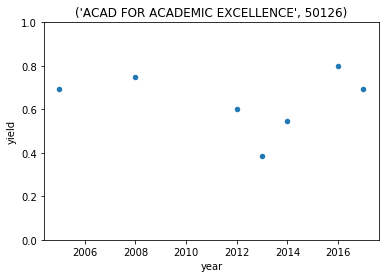

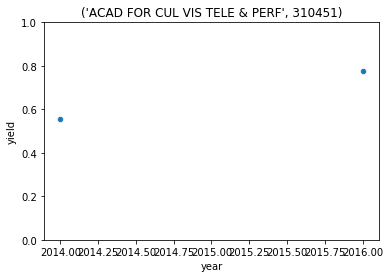

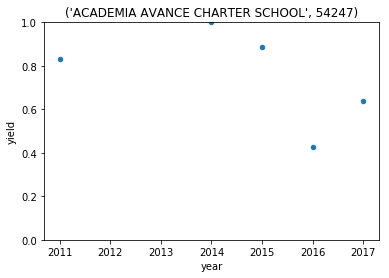

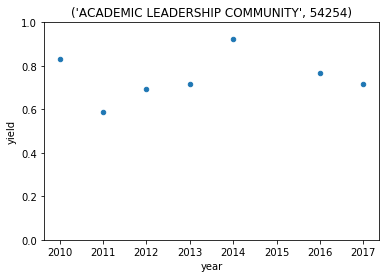

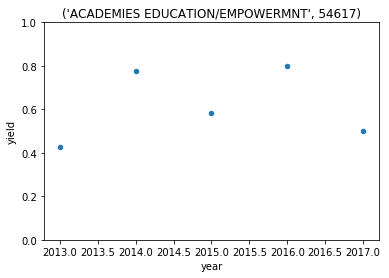

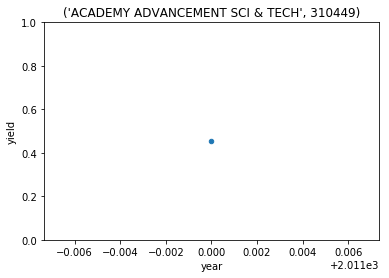

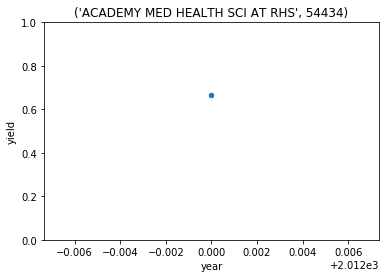

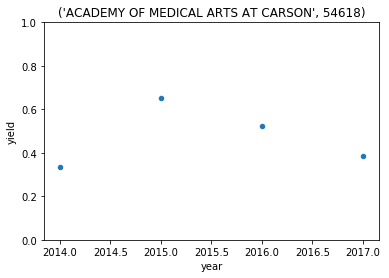

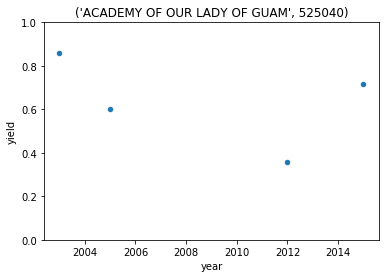

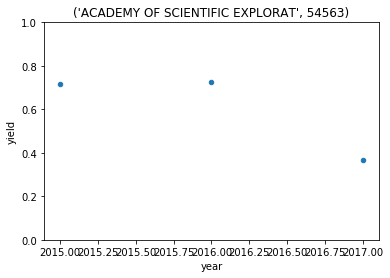

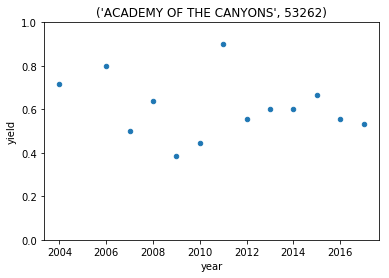

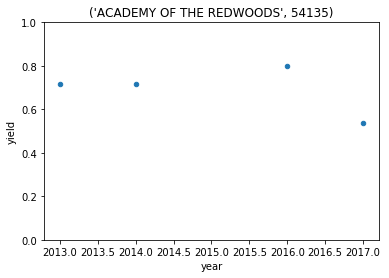

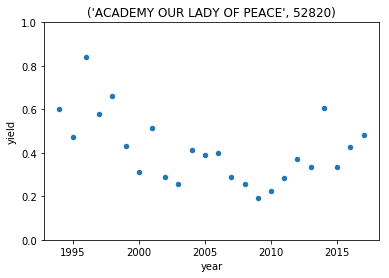

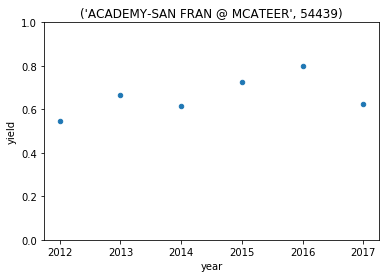

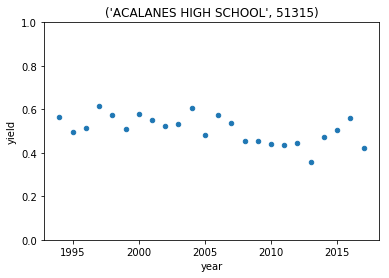

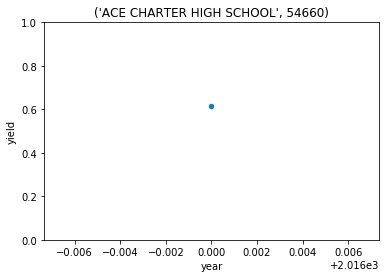

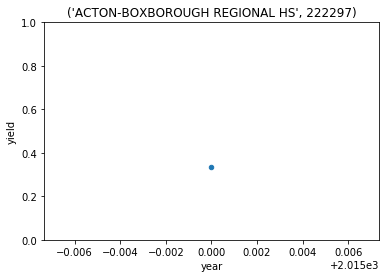

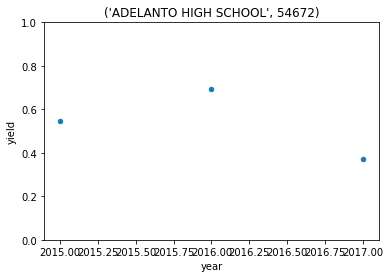

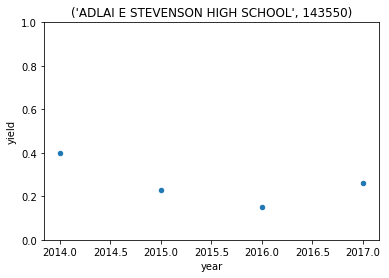

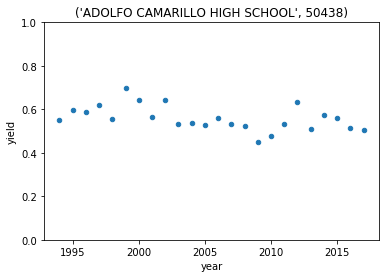

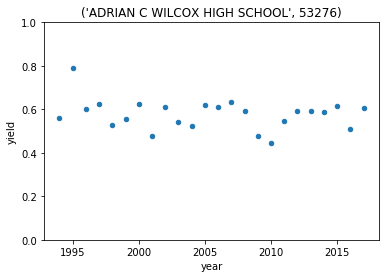

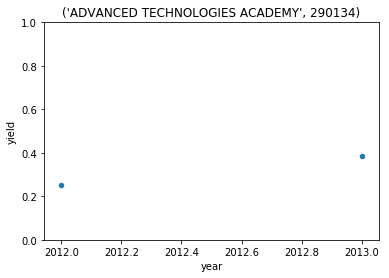

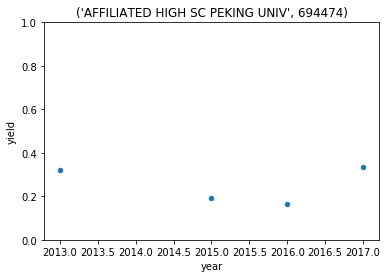

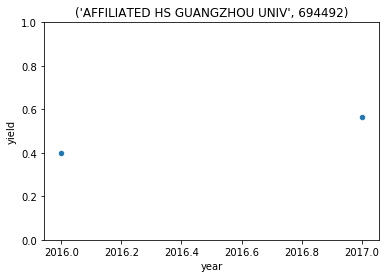

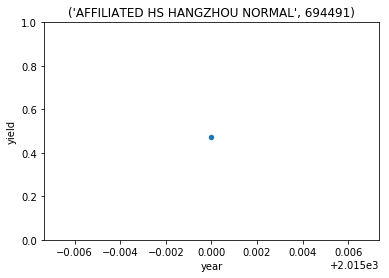

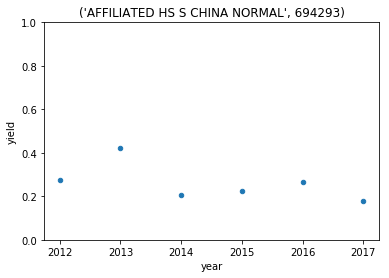

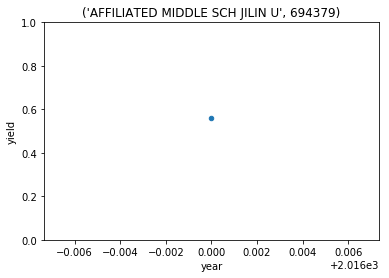

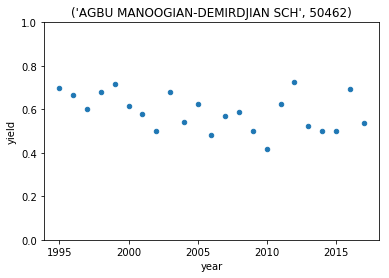

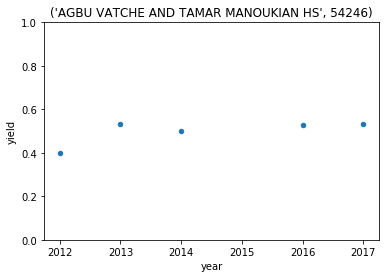

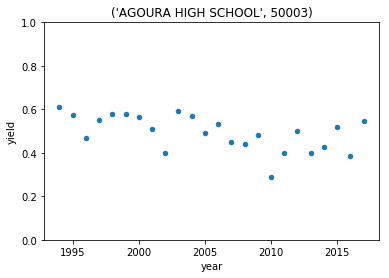

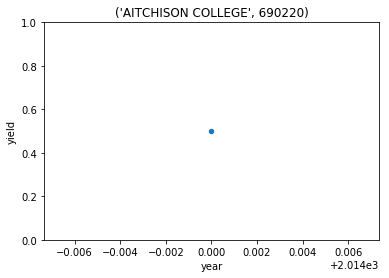

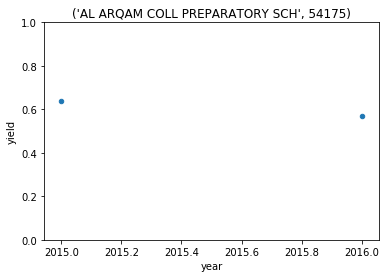

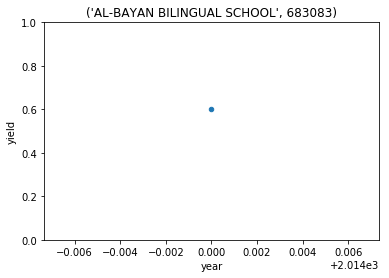

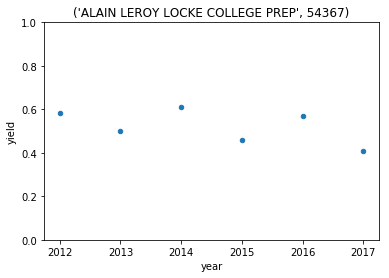

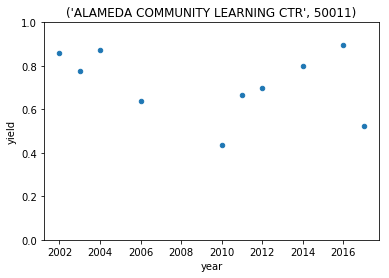

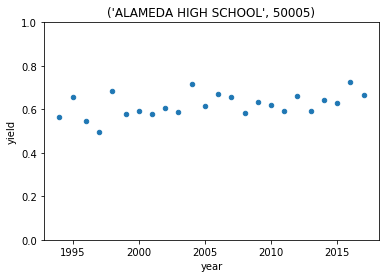

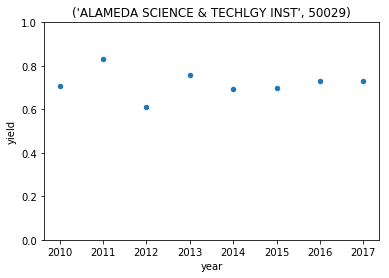

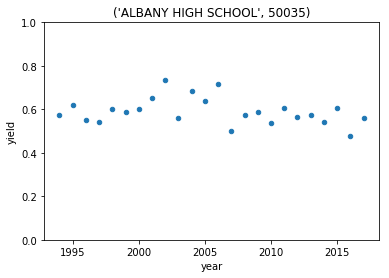

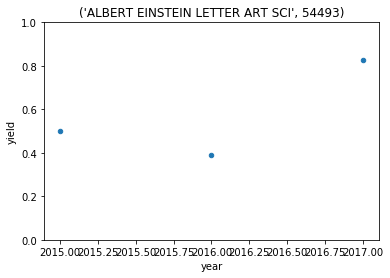

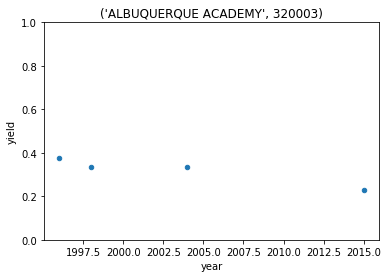

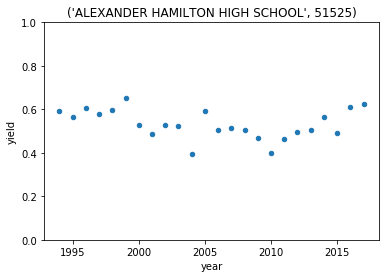

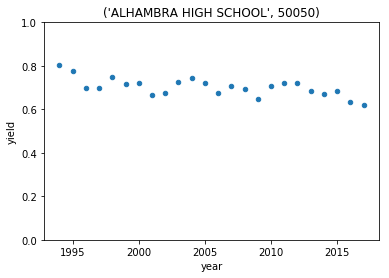

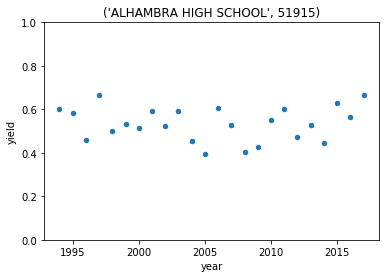

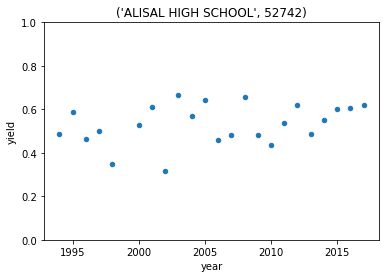

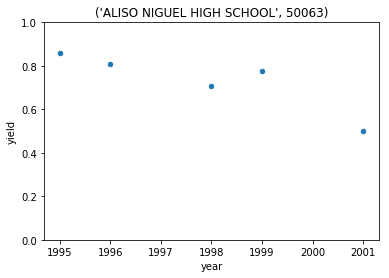

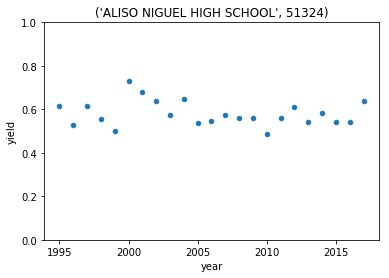

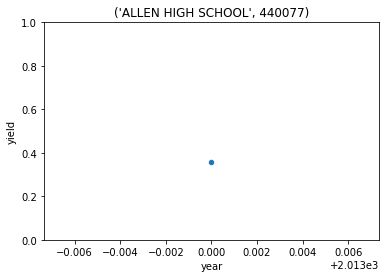

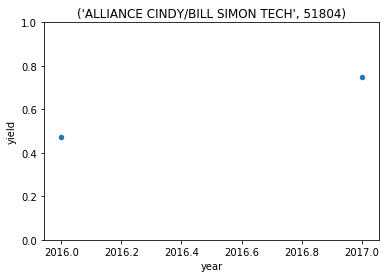

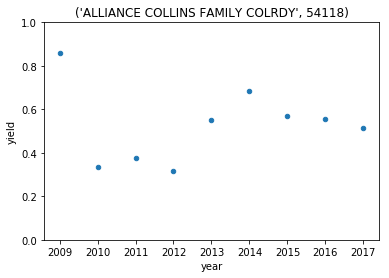

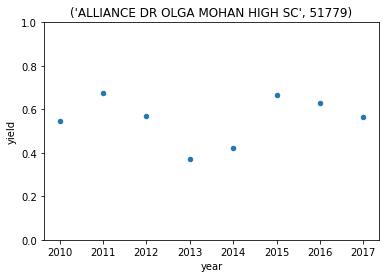

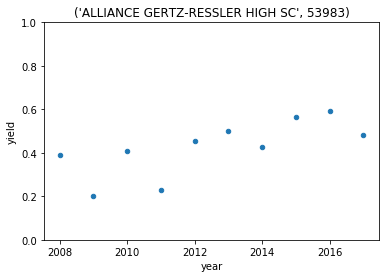

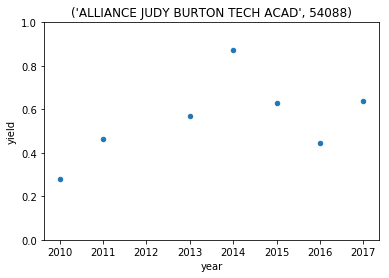

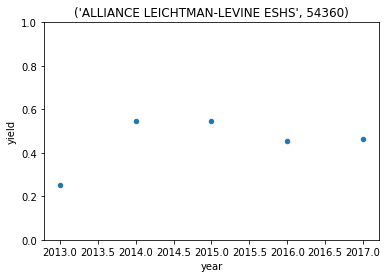

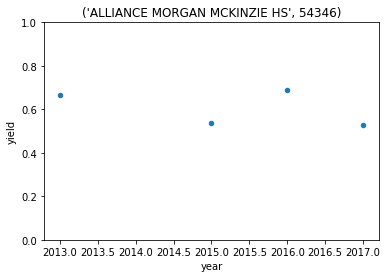

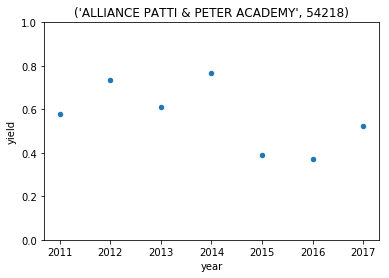

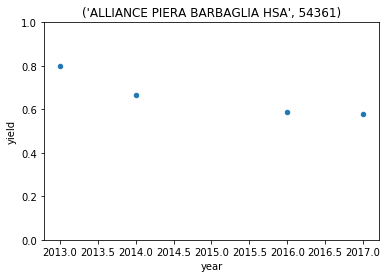

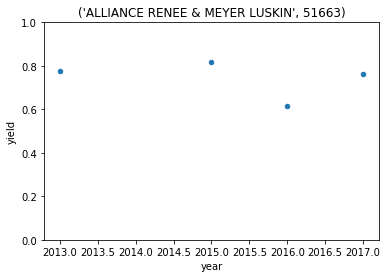

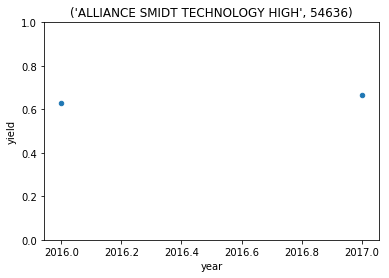

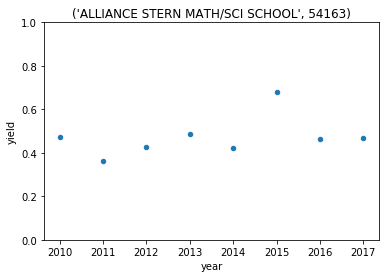

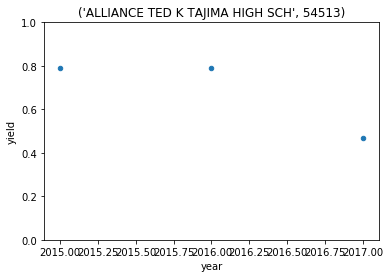

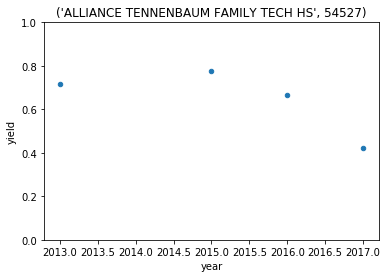

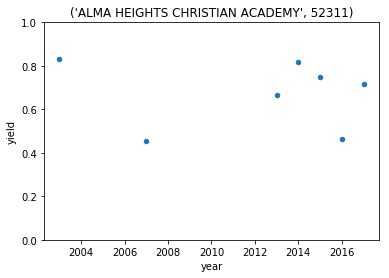

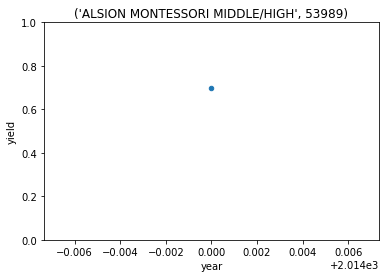

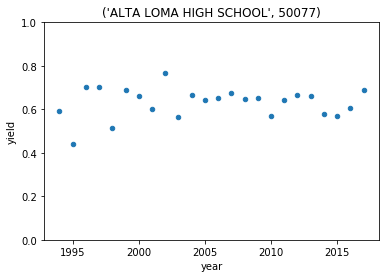

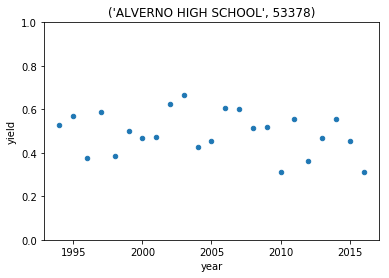

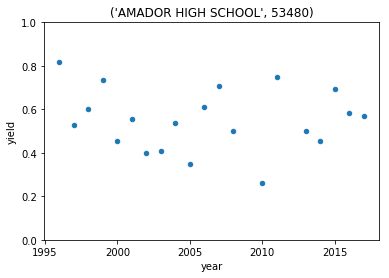

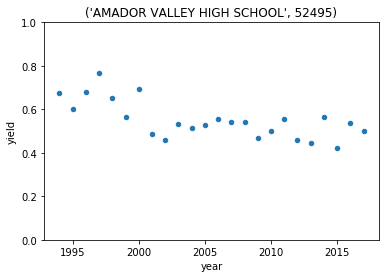

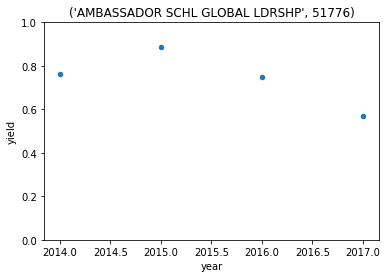

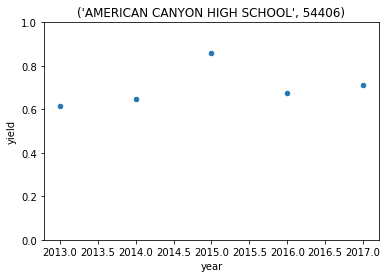

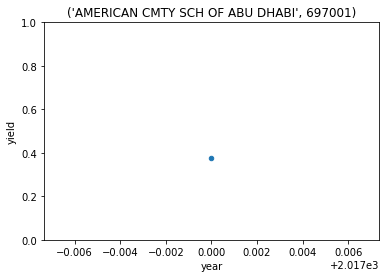

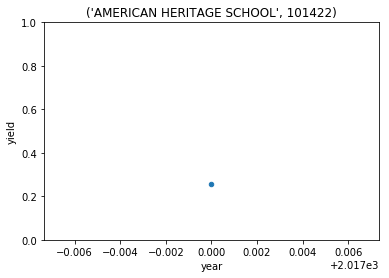

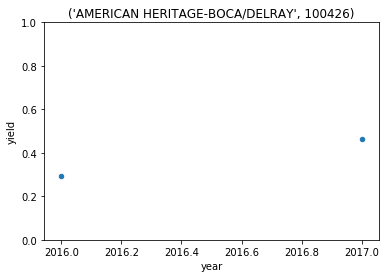

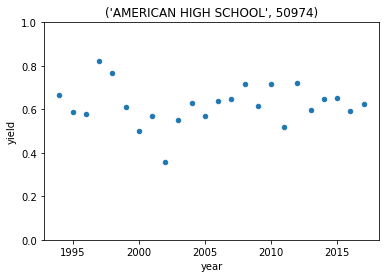

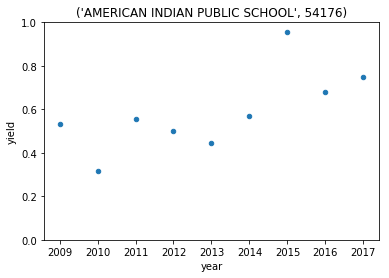

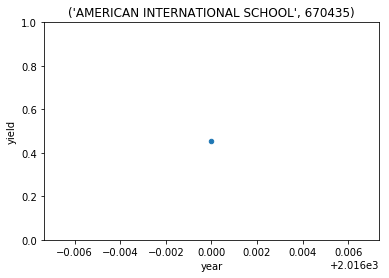

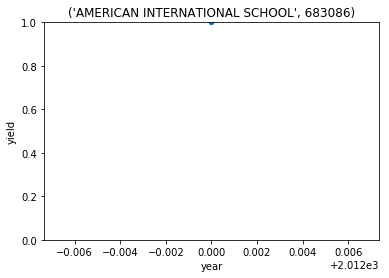

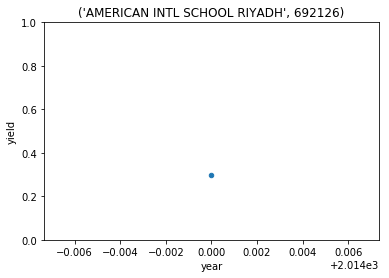

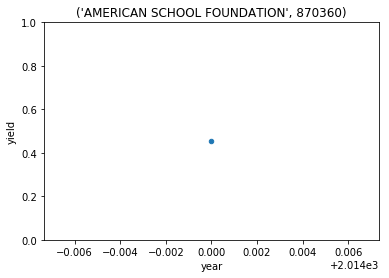

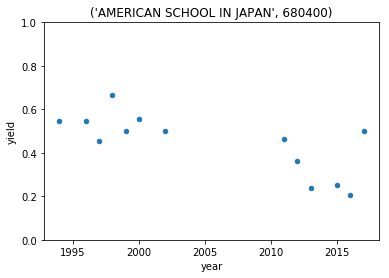

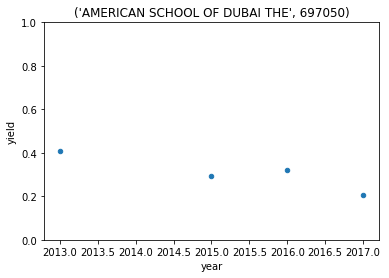

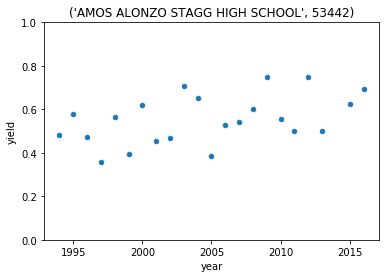

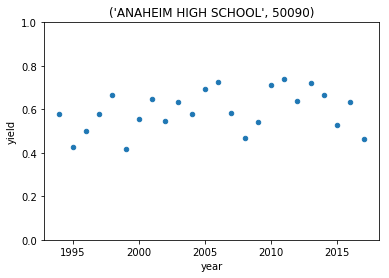

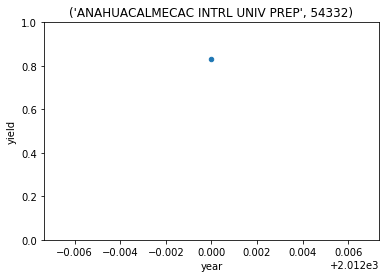

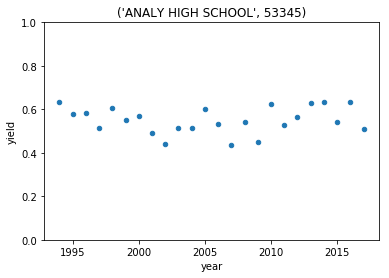

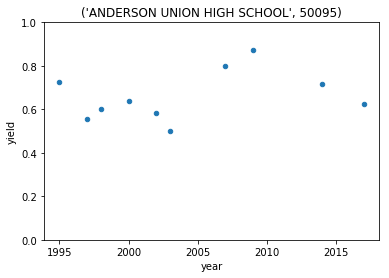

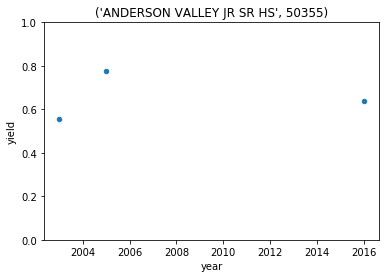

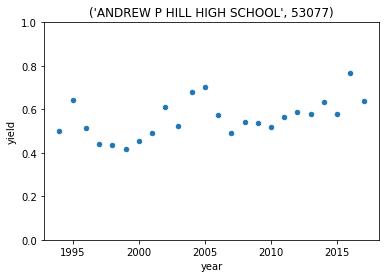

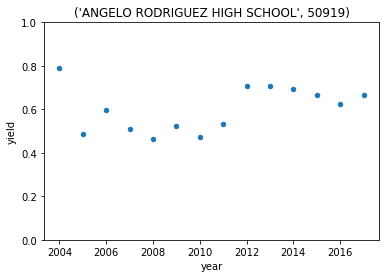

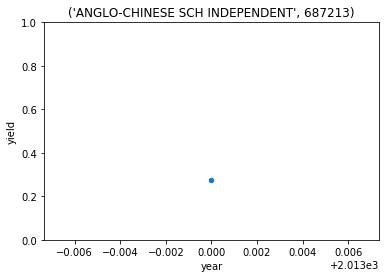

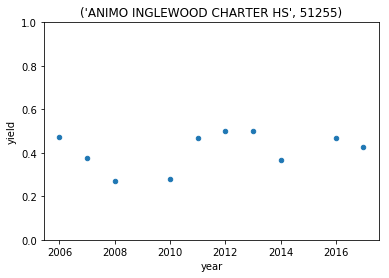

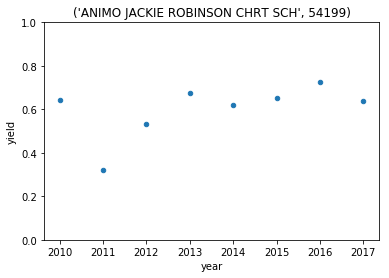

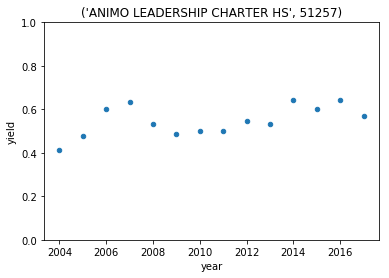

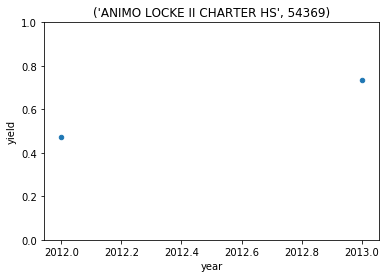

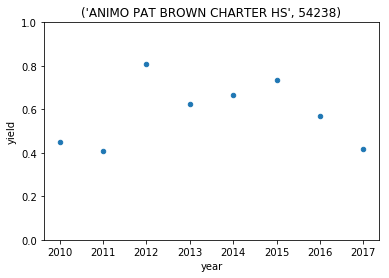

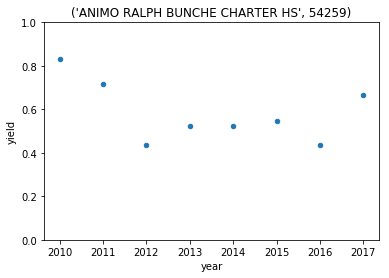

In [23]:
gb = data.loc[(data['ethnicity']=='All') & (data['campus']=='Universitywide')].groupby(["school", "school_num"])
# series = []
i = 0
# print(gb.get_group())
for name, group in gb:
    if group['yield'].count() == 0:
        continue
    group.plot.scatter(x='year', y='yield')
    plt.title(name)
    plt.ylim(0, 1)
    if i > 100:
        break
    i += 1 

It looks like the yield rate is pretty random for each school over time. So to predict the yield for an individual high school for an individual year might be fairly hopeless without knowing the variables that actually caused this.

Now let's see if the yields are different for different schools. Look at the average yield for each school, and then plot a density of them.

In [27]:
avg_yields = gb['yield'].agg(np.mean)
avg_yields

school                            school_num
21ST CENTURY EXPERIMENTAL SCH     694223        0.408333
A & M CONSOLIDATED HIGH SCHOOL    441400             NaN
A B MILLER HIGH SCHOOL            50944         0.605714
A C DAVIS SENIOR HIGH SCHOOL      481601             NaN
A J DIMOND HIGH SCHOOL            20003              NaN
A MACEO SMITH NEW TECH HS         441742             NaN
A N MCCALLUM HIGH SCHOOL          440300             NaN
AAEC SOUTH MOUNTAIN COLG HS       30363              NaN
ABC CHRISTIAN SCHOOL              50131         0.555556
ABERDEEN HIGH SCHOOL              210000             NaN
ABINGTON FRIENDS SCHOOL           391915             NaN
ABINGTON HIGH SCHOOL              390000             NaN
ABRAHAM LINCOLN HIGH SCHOOL       51520         0.654413
                                  52910         0.665233
                                  53075         0.498682
ABSEGAMI HIGH SCHOOL              310759             NaN
ABU DHABI INDIAN SCHOOL           697045   

1032


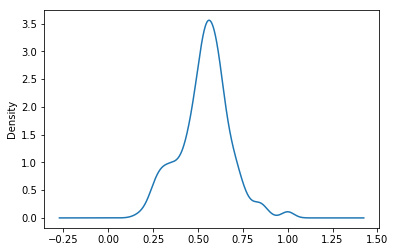

In [26]:
print(avg_yields.count())
avg_yields.plot.density()

So, if we had to guess the yield for a random high school, we should probably pick about .55. But, this could hav significant error. It looks like at least 50% of the data lies outside of the .55 +/- .15 range, so with this stupid guess then half of our predictions would be wrong by at least .15/.55 ~= 30%. This isn't super great. If we could find a predictor for the yield rate of individual high schools that would be very good.